# Desertification detetction using Random Forest and lansat 7 RGB and NDVI, in the souther Tunisia

In [6]:
import os
import warnings
import xarray
import rioxarray
import rasterio
from rasterio.plot import show
import numpy as np
import folium
import rasterio
import pprint
import shutil
from eodag import EODataAccessGateway, setup_logging
warnings.filterwarnings("ignore")

Dowload the most correspondant image in the spring season, covering the training dat

In [5]:
setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
geometry = "POLYGON ((10.307922 33.376233, 10.307922 33.603003, 10.673218 33.603003, 10.673218 33.376233, 10.307922 33.376233))"
search_results, total_count = dag.search(
    productType="LANDSAT_C2L2",
    geom=geometry,
    start="2001-03-01",
    end="2001-04-30",
    cloudCover=10,
)
# The rasterIO python library is used here to display the product (matplotlib is also popular)
# The  line below ourput indicates that two producst were found in the search, and that they have indeed been downloaded using the Creodias provider
pprint.pprint(search_results)
# The targeted product is the first product, the one that covers the Siwa oasis area. The product is stored in the variable "product" that will be used in Section 2
product = search_results[0]
product_path = product.download()
working_path = "./Products/tunisia/landsat7/2001"
shutil.move(product_path, working_path)

[EOProduct(id=LE07_L2SP_190037_20010422_02_T1, provider=planetary_computer),
 EOProduct(id=LT05_L2SP_191037_20010421_02_T2, provider=planetary_computer),
 EOProduct(id=LE07_L2SP_191037_20010413_02_T1, provider=planetary_computer),
 EOProduct(id=LT05_L2SP_191037_20010320_02_T2, provider=planetary_computer),
 EOProduct(id=LT05_L2SP_190037_20010313_02_T1, provider=planetary_computer),
 EOProduct(id=LE07_L2SP_190037_20010305_02_T1, provider=planetary_computer)]


0.00B [00:00, ?B/s]

Error: Destination path './Products/tunisia/landsat7/2001/LE07_L2SP_190037_20010422_02_T1' already exists

Convert the ROI to shpae file to be used in the clip step

In [7]:
#convert the ROI to shpae file
import geopandas as gpd
from shapely import wkt
# WKT representation of the polygon
geometry_wkt = "POLYGON ((10.307922 33.376233, 10.307922 33.603003, 10.673218 33.603003, 10.673218 33.376233, 10.307922 33.376233))"
# Create a GeoDataFrame with the WKT geometry
geometry = wkt.loads(geometry_wkt)
gdf = gpd.GeoDataFrame(geometry=[geometry])
# Set the CRS to WGS84 (EPSG:4326)
gdf.crs = "EPSG:4326"
# Save the GeoDataFrame to a shapefile
gdf.to_file('./Products/tunisia/landsat7/2001/AOI.shp', driver="ESRI Shapefile")

Visualize the Blue band of the downloaded image

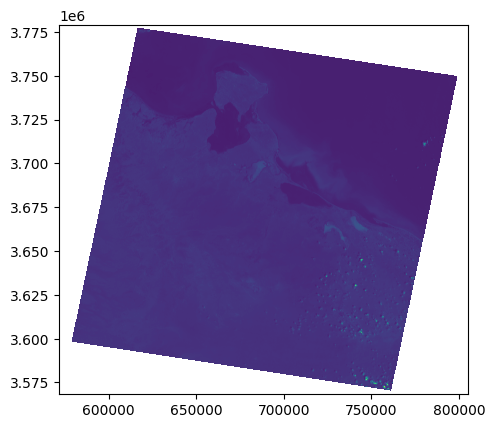

<Axes: >

In [8]:
import glob
from rasterio.plot import show
# Opens the image with rasterio, a python library
img = rasterio.open('./Products/tunisia/landsat7/2001/LE07_L2SP_190037_20010422_02_T1/LE07_L2SP_190037_20010422_20200917_02_T1_SR_B1.TIF')
# Plots the preview image
show(img)

Prepare the 4 bnad (RGB and NIR) to be used for the NDVI claculation and the model traning

In [9]:
# April 22,2001 image bands
base_path = "./Products/tunisia/landsat7/2001/LE07_L2SP_190037_20010422_02_T1/"
blue = rioxarray.open_rasterio(
    os.path.join(base_path, "LE07_L2SP_190037_20010422_20200917_02_T1_SR_B1.TIF")
)  
green = rioxarray.open_rasterio(
    os.path.join(base_path, "LE07_L2SP_190037_20010422_20200917_02_T1_SR_B2.TIF")
) 
red = rioxarray.open_rasterio(
    os.path.join(base_path, "LE07_L2SP_190037_20010422_20200917_02_T1_SR_B3.TIF")
) 
nir = rioxarray.open_rasterio(
    os.path.join(base_path, "LE07_L2SP_190037_20010422_20200917_02_T1_SR_B4.TIF")
) 

In [10]:
print("Red Band dimensions:", red.shape)
print("Green Band dimensions:", green.shape)
print("NIR Band dimensions:", blue.shape)
print("NIR-A Band dimensions:", nir.shape)

Red Band dimensions: (1, 7031, 7781)
Green Band dimensions: (1, 7031, 7781)
NIR Band dimensions: (1, 7031, 7781)
NIR-A Band dimensions: (1, 7031, 7781)


a sample of band (NIR) converted to xarray

In [11]:
nir

<xarray.DataArray (band: 1, y: 7031, x: 7781)>
[54708211 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.718e+05 5.718e+05 ... 8.052e+05 8.052e+05
  * y            (y) float64 3.779e+06 3.779e+06 ... 3.568e+06 3.568e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
# Affect correct name to bands in the data array
red["band"] = ["red"]
green["band"] = ["green"]
blue["band"] = ["blue"]
nir["band"] = ["nir"]

NDVI calculation

In [13]:
dataset_ndvi = xarray.concat([red,nir], dim="band")  # For NDVI
dataset_ndvi = dataset_ndvi.fillna(-1)
NDVI = (dataset_ndvi.sel(band="nir") - dataset_ndvi.sel(band="red")) / (
    dataset_ndvi.sel(band="nir") + dataset_ndvi.sel(band="red")
)
NDVI = NDVI.fillna(-1)  # Clean NDVI data
NDVI.rio.to_raster("./Products/tunisia/landsat7/2001/NDVI.tif")

NDVI visualization

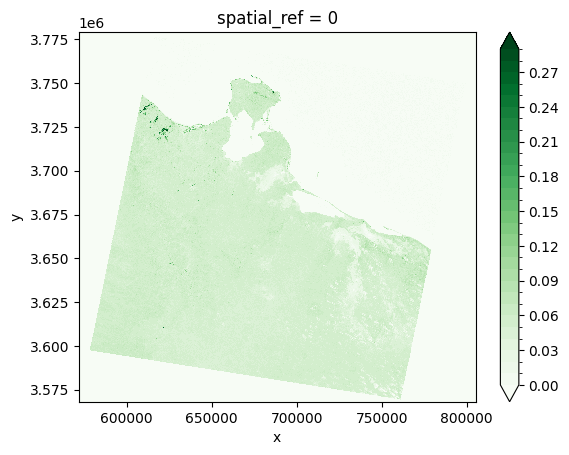

In [14]:
NDVI.plot(levels=np.arange(0, 0.3, 0.01), cmap="Greens")

Normalization of the RGB bands to be used in the model training

In [15]:
# normalization Landsat SR_B1,SR_B2 and SR_B1
Dataset = xarray.concat([red,green,blue], dim="band")  # For NDVI
Dataset = Dataset.fillna(-1)
RED=(Dataset.sel(band="red")*0.0000275)-0.2
RED = RED.fillna(-1)
RED.rio.to_raster("./Products/tunisia/landsat7/2001/RED.tif")

In [16]:
GREEN=(Dataset.sel(band="green")*0.0000275)-0.2
GREEN = GREEN.fillna(-1)
GREEN.rio.to_raster("./Products/tunisia/landsat7/2001/GREEN.tif")

In [17]:
BLUE=(Dataset.sel(band="blue")*0.0000275)-0.2
BLUE = BLUE.fillna(-1)
BLUE.rio.to_raster("./Products/tunisia/landsat7/2001/BLUE.tif")

Creation of the composed image (RGB+NDVI) to used as input in the model

In [18]:
ndvi = rioxarray.open_rasterio( os.path.join("./Products/tunisia/landsat7/2001/", "NDVI.tif")) 
red_norm = rioxarray.open_rasterio( os.path.join("./Products/tunisia/landsat7/2001/RED.tif"))
green_norm = rioxarray.open_rasterio( os.path.join("./Products/tunisia/landsat7/2001/GREEN.tif"))
blue_norm = rioxarray.open_rasterio( os.path.join("./Products/tunisia/landsat7/2001/BLUE.tif"))
Dataset_norm = xarray.concat([red_norm,green_norm,blue_norm,ndvi], dim="band")
Dataset_norm.rio.to_raster("./Products/tunisia/landsat7/2001/RGB_NDVI.tif")

Convert the projection of the composed imge to epsg:4326 for map visualisation and training data extration because the source image is projected in utm epsg:32632

In [19]:
import subprocess
input_tif = "./Products/tunisia/landsat7/2001/RGB_NDVI.tif"
output_tif = "./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326.tif"
# Define the gdal command
gdal_cmd = [
    "gdalwarp",
    "-s_srs", "EPSG:32632",
    "-t_srs", "EPSG:4326",
    "-of", "GTiff",
    "-co", "TFW=YES",
    input_tif,
    output_tif
]
# Run gdalwarp using subprocess
subprocess.run(gdal_cmd)
print("conversion ended")

conversion ended


ERROR 1: Output dataset ./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



Visualization of the projected image

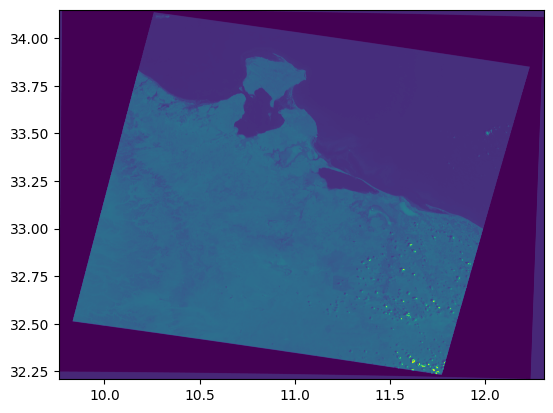

<Axes: >

In [20]:
# Opens the image with rasterio, a python library
raster= rasterio.open('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326.tif')
# Plots the preview image
show(raster,'RGB_NDVI_epsg_4326')

Visulise RGB Bands

Text(0.5, 1.0, 'Blue')

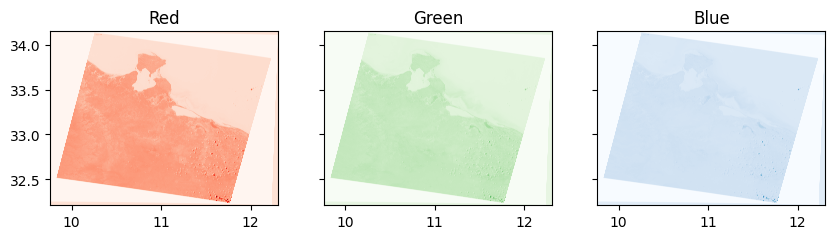

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)
# Plot Red, Green and Blue (rgb)
show((raster, 1), cmap='Reds', ax=ax1)
show((raster, 2), cmap='Greens', ax=ax2)
show((raster, 3), cmap='Blues', ax=ax3)
# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

Extraction of the traing data with an iput shape file points

In [22]:
import geopandas as gpd
import rasterio
import pandas as pd
from shapely.geometry import Point
from rasterio.mask import mask

def extract_pixel_values(geotiff_path, shapefile_path, output_csv):
    # Read shapefile
    gdf = gpd.read_file(shapefile_path)

    # Read GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # Initialize an empty list to store DataFrames
        dfs = []

        # Iterate over each row in the GeoDataFrame
        for index, row in gdf.iterrows():
            # Get the geometry of the feature
            geom = row['geometry']

            # Convert the geometry to GeoJSON format
            geojson = [geom.__geo_interface__]

            # Use rasterio to mask the GeoTIFF based on the geometry
            out_image, out_transform = mask(src, geojson, crop=True)

            # Reshape the image to a 1D array
            pixel_values = out_image.reshape(-1)

            # Extract latitude and longitude from the geometry
            lon, lat = geom.x, geom.y

            # Create a dictionary to store the data
            data_dict = {'lat': lat, 'lon': lon}

            # Add pixel values to the dictionary
            for i, value in enumerate(pixel_values):
                data_dict[f'b{i + 1}'] = value

            # Add class information to the dictionary
            data_dict['class'] = row['class']

            # Create a DataFrame from the dictionary
            df = pd.DataFrame(data_dict, index=[0])

            # Append the DataFrame to the list
            dfs.append(df)

        # Concatenate all DataFrames in the list
        result_df = pd.concat(dfs, ignore_index=True)

    # Save the result DataFrame to a CSV file
    result_df.to_csv(output_csv, index=False)

# Example usage
extract_pixel_values('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326.tif', './Products/tunisia/landsat7/2001/insitu_Jef_1400_point.shp', './Products/tunisia/landsat7/2001/train.csv')
print("traing data preparation ended")

traing data preparation ended


Traing data head

In [23]:
train_frame_2001 = pd.read_csv('./Products/tunisia/landsat7/2001/train.csv')
train_frame_2001.head()

,lat,lon,b1,b2,b3,b4,class
0,33.523418,10.406052,0.447020,0.310262,0.186512,0.047777,2
1,33.380012,10.189982,0.347277,0.229852,0.134510,0.057361,0
2,33.461570,10.344591,0.397135,0.271405,0.166602,0.044152,1
3,33.497244,10.396088,0.387043,0.248910,0.135885,0.063235,2
4,33.365491,10.179778,0.384925,0.257985,0.155190,0.057348,2


Traing data visualisation in the map

In [27]:
import folium
import pandas as pd
from IPython.display import display

# Read the CSV file
df = pd.read_csv('./Products/tunisia/landsat7/2001/train.csv')
# Create a Folium map centered at the mean of latitudes and longitudes
map_center = [df['lat'].mean(), df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=10)
# Add circles (points) to the map with different colors based on the 'class' column
for index, row in df.iterrows():
    color = 'green' if row['class'] == 0 else 'yellow' if row['class'] == 1 else 'red'
    folium.Circle(
        location=[row['lat'], row['lon']],
        radius=2,
        color=color,
        fill=True,
        name='Training data',
        fill_color=color,
        popup=f'Class: {row["class"]}'
    ).add_to(m)
# Create a legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; opacity: 0.85;
                 ">
     &nbsp; <b>Desertification Risk</b> <br>
      &nbsp;<i class="fa fa-circle" style="color:green; width: 10px; height: 10px;"></i> &nbsp; Low<br>
      &nbsp;<i class="fa fa-circle" style="color:yellow; width: 10px; height: 10px;"></i> &nbsp; High<br>
      &nbsp;<i class="fa fa-circle" style="color:red; width: 10px; height: 10px;"></i> &nbsp; Very High
      </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))
# Add a layer control to the map
folium.LayerControl().add_to(m)
# Display the map
m

Model input preparation

In [28]:
from sklearn.model_selection import train_test_split
import numpy
train_data_2001=np.array(train_frame_2001.iloc[:, 2:6])
data_y=np.array(train_frame_2001.iloc[:, 6:7])
x_train, x_test = train_test_split(train_data_2001, test_size = 0.2, random_state = 0)
y_train, y_test = train_test_split(data_y, test_size = 0.2, random_state = 0)

Random Forest Model creation

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(x_train, y_train);

Model Accuracy

In [30]:
from sklearn.metrics import accuracy_score
# Make predictions for all the train set
y_pred= rf.predict(train_data_2001)
# View accuracy score
accuracy_score(data_y, y_pred)

0.8966216216216216

Confusion Matrix

<Axes: >

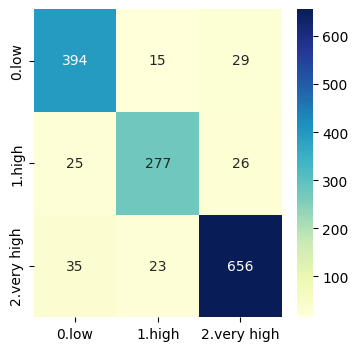

In [31]:
import seaborn as sn
import sklearn
import matplotlib.pyplot as plt
confusion_mat=sklearn.metrics.confusion_matrix(data_y, y_pred)
df_cm = pd.DataFrame(confusion_mat, index = ["0.low","1.high","2.very high"],columns = ["0.low","1.high","2.very high"])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")

Clip the projected image with  AOI shape file to predict the desertification in the AOI 

In [32]:
#clip step
import subprocess
# Replace the paths with your actual paths
shapefile_path = "./Products/tunisia/landsat7/2001/AOI.shp"
input_tif = "./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326.tif"
output_tif = "./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.tif"

# Construct the gdalwarp command as a list of arguments
gdalwarp_command = [
    "gdalwarp",
    "-cutline", shapefile_path,
    "-crop_to_cutline",
    input_tif,
    output_tif
]

# Execute the gdalwarp command using subprocess
subprocess.run(gdalwarp_command)
print('Clip process ended')

Clip process ended


ERROR 1: Output dataset ./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



Show clipped image

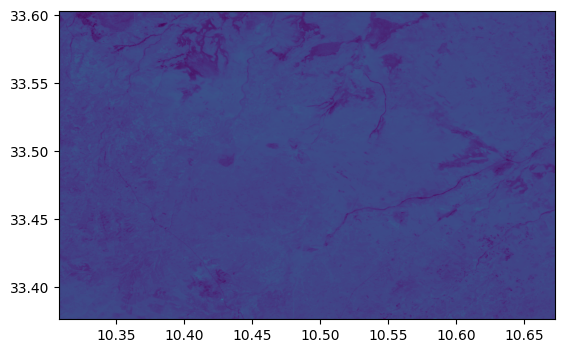

<Axes: >

In [33]:
import glob
# We import the rasterIO library, that can read and display a Georeferenced image
from rasterio.plot import show
# Opens the image with rasterio, a python library
img = rasterio.open('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.tif')
# Plots the preview image
show(img)

Display the clipped image in the map


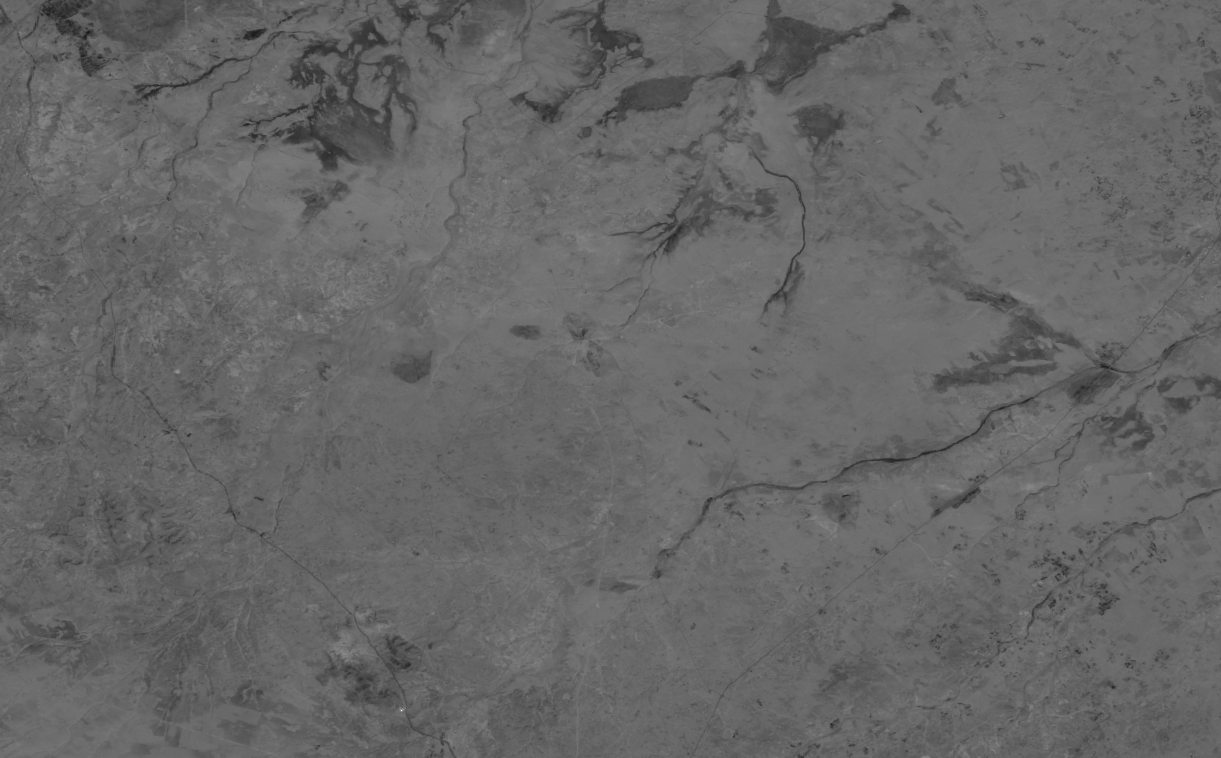

In [34]:
import folium
import rasterio
from matplotlib.colors import LinearSegmentedColormap
from folium import plugins
# Open rasterio dataset
img_path = './Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.tif'
img = rasterio.open(img_path)
# Get image bounds
bounds = [(img.bounds.bottom, img.bounds.left), (img.bounds.top, img.bounds.right)]
# Create a grayscale colormap
cmap = LinearSegmentedColormap.from_list('grayscale', [(0, 'black'), (1, 'white')], N=256)
# Create a Folium map centered at the mean of the bounds
center = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2]
m = folium.Map(location=center, zoom_start=10)
# Add the raster image to the map with a custom name, grayscale colormap, and opacity set to 1
folium.raster_layers.ImageOverlay(
    image=img.read(1),
    bounds=bounds,
    colormap=cmap,
    opacity=1,  
    name='Image Clipped'  
).add_to(m)
# Add a layer control to the map
folium.LayerControl().add_to(m)
# Display the map
m

show image clipped RGB bands

Text(0.5, 1.0, 'Blue')

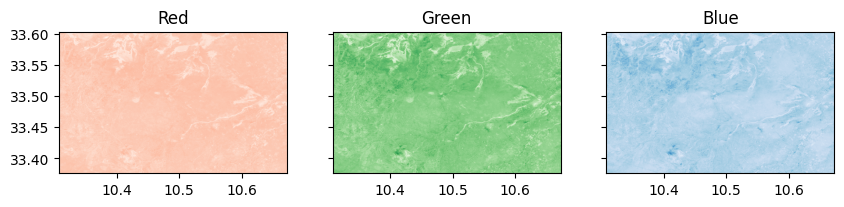

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)
# Plot Red, Green and Blue (rgb)
show((img, 1), cmap='Reds', ax=ax1)
show((img, 2), cmap='Greens', ax=ax2)
show((img, 3), cmap='Blues', ax=ax3)
# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

Prepare the clipped image as a csv file for prediction by the RF model

In [ ]:
from osgeo import gdal
import csv
import numpy as np
def get_lat_lon_from_pixel(dataset, x, y):
    # Get the geotransform information
    geotransform = dataset.GetGeoTransform()
    # Calculate the latitude and longitude
    lon = geotransform[0] + x * geotransform[1] + y * geotransform[2]
    lat = geotransform[3] + x * geotransform[4] + y * geotransform[5]

    return lat, lon
def tif_to_csv(tif_path, csv_path):
    # Open the TIF file
    dataset = gdal.Open(tif_path)
    if dataset is None:
        print("Error: Unable to open the TIF file.")
        return

    # Get the number of bands
    num_bands = dataset.RasterCount

    # Create a CSV file for writing
    with open(csv_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Write header with band names, latitude, and longitude
        header = ['lat', 'lon']
        for band_num in range(1, num_bands + 1):
            header.append(f'Band_{band_num}')
        csv_writer.writerow(header)

        # Iterate through each pixel and write to CSV
        for y in range(dataset.RasterYSize):
            for x in range(dataset.RasterXSize):
                pixel_data = []

                # Get latitude and longitude
                lat, lon = get_lat_lon_from_pixel(dataset, x, y)
                pixel_data.extend([lat, lon])

                # Get pixel values for each band
                for band_num in range(1, num_bands + 1):
                    band = dataset.GetRasterBand(band_num)
                    pixel_value = band.ReadAsArray(x, y, 1, 1)[0, 0]

                    # Check for NaN values
                    if np.isnan(pixel_value):
                        continue

                    pixel_data.append(pixel_value)

                # Write the row only if there are no NaN values
                if len(pixel_data) == num_bands + 2:  # +2 for Latitude and Longitude
                    csv_writer.writerow(pixel_data)

    # Close the TIF dataset
    dataset = None
tif_to_csv('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.tif', './Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.csv')
print('csv file creation ended')

Show the head of the csv file: Band_1: Red, Band_2: Green, Band_3: Blue and Band_4: NDVI

In [ ]:
data_frame_2001 = pd.read_csv('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.csv')
data_frame_2001.head()

Predict desertification and save it in the csv file

In [ ]:
import pandas as pd
dataframe2001 = pd.read_csv('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.csv')
dataframe2001 = dataframe2001[dataframe2001 != -1].dropna()
dataset2001=np.array(dataframe2001.iloc[:, 2:6])
# Make predictions for AOI
y_pred_AOI= rf.predict(dataset2001)
dataframe2001['class']=y_pred_AOI
dataframe2001.to_csv(r'./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.csv')

Show the head of the result

In [ ]:
data_frame_2001 = pd.read_csv('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.csv')
data_frame_2001

Display the results in a foluim map

In [ ]:
import folium
import pandas as pd
from IPython.display import display

# Read the CSV file
df = pd.read_csv('./Products/tunisia/landsat7/2001/RGB_NDVI_epsg_4326_cliped.csv')
# Get a random sample of 20000 lines
random_sample_df = df.sample(n=20000)
# Create a Folium map centered at the mean of latitudes and longitudes
map_center = [random_sample_df['lat'].mean(),random_sample_df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=10)
# Add circles (points) to the map with different colors based on the 'class' column
for index, row in random_sample_df.iterrows():
    color = 'green' if row['class'] == 0 else 'yellow' if row['class'] == 1 else 'red'
    folium.Circle(
        location=[row['lat'], row['lon']],
        radius=0.1,
        color=color,
        fill=True,
        fill_color=color,
        popup=f'Class: {row["class"]}'
    ).add_to(m)
# Create a legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; opacity: 0.85;
                 ">
     &nbsp; <b>Desertification Risk</b> <br>
      &nbsp;<i class="fa fa-circle" style="color:green; width: 10px; height: 10px;"></i> &nbsp; Low<br>
      &nbsp;<i class="fa fa-circle" style="color:yellow; width: 10px; height: 10px;"></i> &nbsp; High<br>
      &nbsp;<i class="fa fa-circle" style="color:red; width: 10px; height: 10px;"></i> &nbsp; Very High
      </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))
# Display the map
m